# RQ4: How frequently do developers use the conversion functions?


## Data Preparation

In [59]:
from pathlib import Path
from nb_utils import unzip, DATA_DIR, RESULTS_DIR
import pandas as pd
import os

# Extracted results, load to frame and delete the large CSV
unzip(DATA_DIR / 'sfconvertbot_pr_metadata.csv.zip', DATA_DIR)
df = pd.read_csv(Path('../../data/sfconvertbot_pr_metadata.csv'))
os.remove(DATA_DIR / 'sfconvertbot_pr_metadata.csv')

# series for collecting dataset stats, columns = metric / value
stats = pd.Series()
stats.loc['Number of PRs collected from SFConvertBot Community Activity'] = len(df)

# remove rows with missing values
df = df.dropna()
stats.loc['Number of PRs after removing missing values'] = len(df)

# remove rows with invalid JSONs
df = df[df['discussion_metadata'].str.startswith('{')]
stats.loc['Number of PRs after removing invalid JSONs'] = len(df)

# add a date column
df['date'] = df['time'].str.split('T').str[0]
df['date'] = df['date'].str.split(' ').str[0]
# ensure date column is a datetime object
df['date'] = pd.to_datetime(df['date'])
# filter in place, keep only commits before Oct 31 2024 (including)
df = df[df['date'] <= pd.Timestamp(2024, 10, 31)]
stats.loc['Number of PRs after filtering by date'] = len(df)

# exclude PRs made on spaces/safetensors/convert
df = df[~df['pr_url'].str.contains('/spaces/safetensors/convert/discussions')]
stats.loc['Number of PRs after filtering by URL'] = len(df)

# show some stats
stats.loc['Number of repositories'] = df['model_id'].nunique()
stats.loc['Average number of PRs per repository'] = df['model_id'].value_counts().mean()
stats.loc['First commit time'] = df['time'].min()
stats.loc['Last commit time'] = df['time'].max()
# save stats to csv
stats.to_csv(RESULTS_DIR / 'rq4_dataset_stats.csv', header=False)

## Extracting PR Statuses


In [ ]:
from tqdm import tqdm
import json


def label_status(row: pd.Series) -> str:
    # check if the PR has conflicts
    if row['conflicts']:
        return f"{row['status']} (has conflicts)"
    return row['status']


# Extract status changes from discussion metadata
for index, row in tqdm(df.iterrows(), total=len(df)):
    # add a column to track status changes
    status_changes = []
    discussion = json.loads(row['discussion_metadata'])['discussion']
    created_at = pd.to_datetime(discussion['createdAt'])
    author = discussion['author']['name']
    
    first_status_change_date = None
    df.at[index, 'was_status_changed_by_hf_staff'] = False
    for event in discussion['events']:
        event_type = event['type']
        
        if event_type == 'status-change':
            status_changes.append(event['data']['status'])
            # this means author has been deleted
            if 'author' not in event:
                event['author'] = {'name': 'UNKNOWN (likely a deleted account)', 'isHf':False}
            
            # convert to datetime
            if not first_status_change_date and event['author']['name'].lower() != 'sfconvertbot':
                first_status_change_date = pd.to_datetime(event['createdAt'])
                if event['author']['isHf']:
                    df.at[index, 'was_status_changed_by_hf_staff'] = True

    df.at[index, 'status_changes'] = ";".join(status_changes)

    # add a column to track files with conflicts
    df.at[index, 'conflicts'] = ""
    header = json.loads(row['header_metadata'])
    df.at[index, 'status'] = header['discussion']['status']
    # check if there are conflicting files
    conflicting_files = header['discussion'].get('filesWithConflicts', [])
    df.at[index, 'conflicts'] = ";".join(conflicting_files)
    # time to first response
    df.at[
        index, 'time_to_first_response'] = first_status_change_date - created_at if first_status_change_date else "No response"
    # adjust the status
    df.at[index, 'status'] = label_status(df.loc[index])
    # Add a year column
    df['year'] = df['date'].dt.year

# show only those in 2022
# df_2022 = df1[df1['date'].dt.year == 2022]


In [80]:
df[df['date'].dt.year == 2022]

,pr_url,discussion_metadata,header_metadata,model_id,time,date,was_status_changed_by_hf_staff,status_changes,conflicts,status,time_to_first_response,year
45394,https://huggingface.co/julien-c/hotdog-not-hot...,"{""apiBaseUrl"":""/api/models/julien-c/hotdog-not...","{""discussion"":{""_id"":""63690187da9b693c272fa24b...",julien-c/hotdog-not-hotdog,2022-11-07T13:00:55.000Z,2022-11-07,NaN,NaN,NaN,NaN,NaN,2022
45395,https://huggingface.co/julien-c/hotdog-not-hot...,"{""apiBaseUrl"":""/api/models/julien-c/hotdog-not...","{""discussion"":{""_id"":""6369033585fef3ca96e226c1...",julien-c/hotdog-not-hotdog,2022-11-07T13:08:05.000Z,2022-11-07,NaN,NaN,NaN,NaN,NaN,2022
45396,https://huggingface.co/Bingsu/clip-vit-base-pa...,"{""apiBaseUrl"":""/api/models/Bingsu/clip-vit-bas...","{""discussion"":{""_id"":""636a36ebfbc31ee68fee9d2d...",Bingsu/clip-vit-base-patch32-ko,2022-11-08T11:00:59.000Z,2022-11-08,NaN,NaN,NaN,NaN,NaN,2022
45397,https://huggingface.co/bert-base-uncased/discu...,"{""apiBaseUrl"":""/api/models/google-bert/bert-ba...","{""discussion"":{""_id"":""636cc5fcdd7265f81aa0e280...",bert-base-uncased,2022-11-10T09:35:56.000Z,2022-11-10,NaN,NaN,NaN,NaN,NaN,2022
45398,https://huggingface.co/Norod78/hebrew-gpt_neo-...,"{""apiBaseUrl"":""/api/models/Norod78/hebrew-gpt_...","{""discussion"":{""_id"":""636cd3c0d963c5679361edd2...",Norod78/hebrew-gpt_neo-small,2022-11-10T10:34:40.000Z,2022-11-10,NaN,NaN,NaN,NaN,NaN,2022
...,...,...,...,...,...,...,...,...,...,...,...,...
45483,https://huggingface.co/yehiaserag/anime-pencil...,"{""apiBaseUrl"":""/api/models/yehiaserag/anime-pe...","{""discussion"":{""_id"":""63a82fd0a8066873e9171427...",yehiaserag/anime-pencil-diffusion,2022-12-25T11:11:12.000Z,2022-12-25,NaN,NaN,NaN,NaN,NaN,2022
45485,https://huggingface.co/Fictiverse/Stable_Diffu...,"{""apiBaseUrl"":""/api/models/Fictiverse/Stable_D...","{""discussion"":{""_id"":""63aa35b057ca9193a67cba06...",Fictiverse/Stable_Diffusion_PaperCut_Model,2022-12-27T00:00:48.000Z,2022-12-27,NaN,NaN,NaN,NaN,NaN,2022
45487,https://huggingface.co/22h/vintedois-diffusion...,"{""apiBaseUrl"":""/api/models/22h/vintedois-diffu...","{""discussion"":{""_id"":""63ac6e0323f39d70bdd0e49b...",22h/vintedois-diffusion-v0-1,2022-12-28T16:25:39.000Z,2022-12-28,NaN,NaN,NaN,NaN,NaN,2022
45488,https://huggingface.co/wavymulder/timeless-dif...,"{""apiBaseUrl"":""/api/models/wavymulder/timeless...","{""discussion"":{""_id"":""63af52764afc56c8d3b6b375...",wavymulder/timeless-diffusion,2022-12-30T21:04:54.000Z,2022-12-30,NaN,NaN,NaN,NaN,NaN,2022


## Stacked bar chart per year for the distribution of different status.


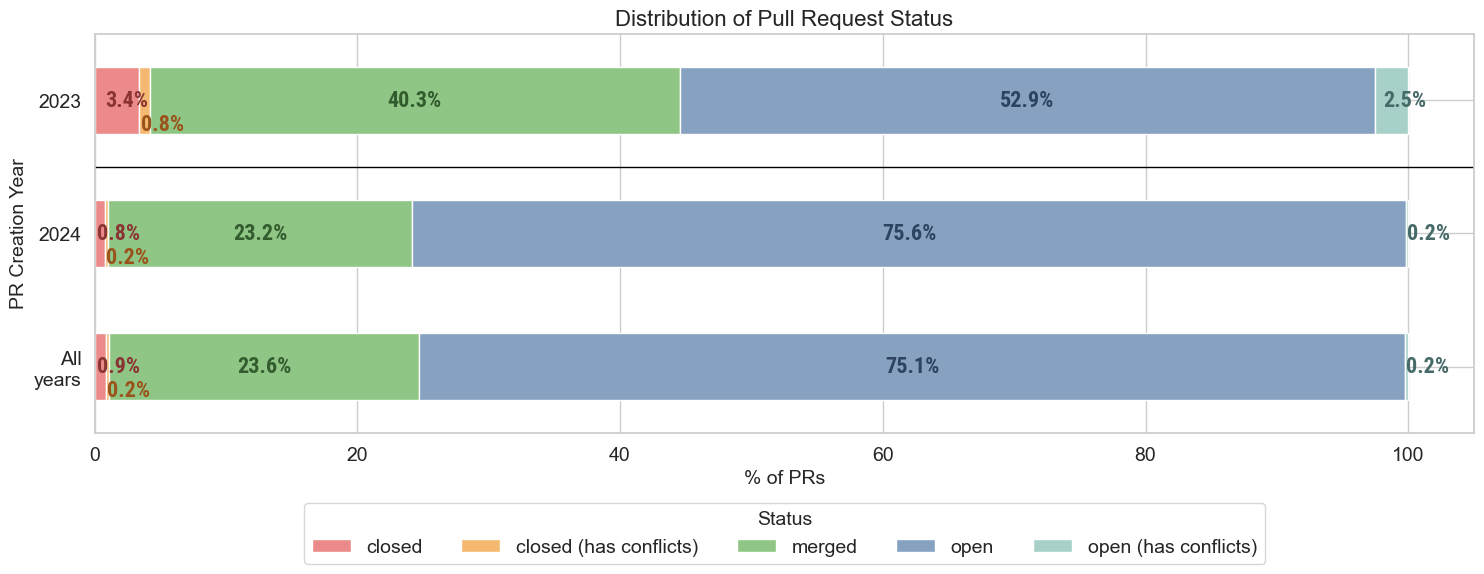

,pr_url,status,year,was_status_changed_by_hf_staff
235,https://huggingface.co/osunlp/attrscore-flan-t...,open,2024,False
236,https://huggingface.co/Dheeraj46329/llama-3.2-...,merged,2024,False
237,https://huggingface.co/Dheeraj46329/llama-3.2-...,merged,2024,False
238,https://huggingface.co/BAAI/Emu2/discussions/4...,open,2024,False
239,https://huggingface.co/royweiss1/T5_MiddleSent...,open,2024,False
...,...,...,...,...
46315,https://huggingface.co/pchatz/palobert-base-gr...,NaN,2023,NaN
46316,https://huggingface.co/Merry/pythia-160m-dedup...,NaN,2023,NaN
46321,https://huggingface.co/babylm/t5-base-strict/d...,NaN,2023,NaN
46322,https://huggingface.co/zhaozh/autotrain-pubmed...,NaN,2023,NaN


In [85]:
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
from nb_utils import RESULTS_DIR

# Group by year and status, and calculate counts
status_counts = df.groupby(['year', 'status']).size().unstack(fill_value=0)

# Calculate percentage distribution for each year
status_percentage = status_counts.div(status_counts.sum(axis=1), axis=0) * 100

# Calculate total counts for all years and add as a new row
total_counts = df['status'].value_counts(normalize=True) * 100  # Percentage distribution for the entire dataset
status_percentage.loc['All\nyears'] = total_counts.reindex(status_percentage.columns).fillna(0)  # Add 'Total' row


# Reverse the order of the years to display from bottom to top
status_percentage = status_percentage[::-1]

# Define Tableau-like color palette for the status categories
colors = {
    'open': '#87a1c1',  # Lighter Blue
    'merged': '#8fc685',  # Lighter Green
    'closed': '#ec8a89',  # Lighter Red
    'closed (has conflicts)': '#f5b870',  # Lighter Orange
    'open (has conflicts)': '#a7d0c8',  # Lighter Teal
}

# Define even darker versions of the Tableau-like color palette
darker_colors = {
    'open': '#2d4460',  # Even Darker Blue
    'merged': '#325c2d',  # Even Darker Green
    'closed': '#8a3434',  # Even Darker Red
    'closed (has conflicts)': '#9a531b',  # Even Darker Orange
    'open (has conflicts)': '#466a68',  # Even Darker Teal
}

# Load the Roboto Condensed font from your local assets folder
roboto_condensed = FontProperties(fname='../../assets/RobotoCondensed-Bold.ttf')

# Plot the 100% stacked bar chart as horizontal with Tableau-like colors
fig, ax = plt.subplots(figsize=(15, 6))
status_percentage.plot(kind='barh', stacked=True, ax=ax, color=[colors[status] for status in status_percentage.columns])

# Add data labels for each segment with matching colors
for i, (year, row) in enumerate(status_percentage.iterrows()):
    cumulative = 0
    delta = 0.18  # Offset for small segments
    was_small = False
    for status, value in row.items():
        if value > 5:  # Only display labels for segments > 5% to prevent overlap
            ax.text(cumulative + value / 2, i, f"{value:.1f}%", ha='center', va='center',
                    fontsize=16, fontweight='bold', fontproperties=roboto_condensed,
                    color=darker_colors[status])  # Set text color to match bar color
            was_small = False
        elif value > 0:
            # For small segments, place the label outside with matching color
            ax.text(cumulative + value / 4, i + (delta if was_small else 0), f"{value:.1f}%", ha='left', va='center',
                    fontsize=16, fontweight='bold', fontproperties=roboto_condensed,
                    color=darker_colors[status])
            delta = -delta
            was_small = True
        cumulative += value

# Add a red line separating the "Total" bar from the yearly data
ax.axhline(y=len(status_percentage) - 1.5, color='black', linewidth=1)

# Customize plot with larger font sizes
plt.title('Distribution of Pull Request Status', fontsize=16)
plt.ylabel('PR Creation Year', fontsize=14)
plt.xlabel('% of PRs', fontsize=14)
# increase tick size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Move the legend outside and below the chart with increased label size
plt.legend(title='Status', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=len(status_percentage.columns),
           fontsize=14, title_fontsize=14)
plt.tight_layout()

# Save the plot to a PDF
plt.savefig(RESULTS_DIR / 'RQ4StatusDistribution.pdf', format='pdf', bbox_inches='tight')


plt.show()
df[['pr_url', 'status', 'year', 'was_status_changed_by_hf_staff']]

## How many PRs are merged by a hugging face staff?


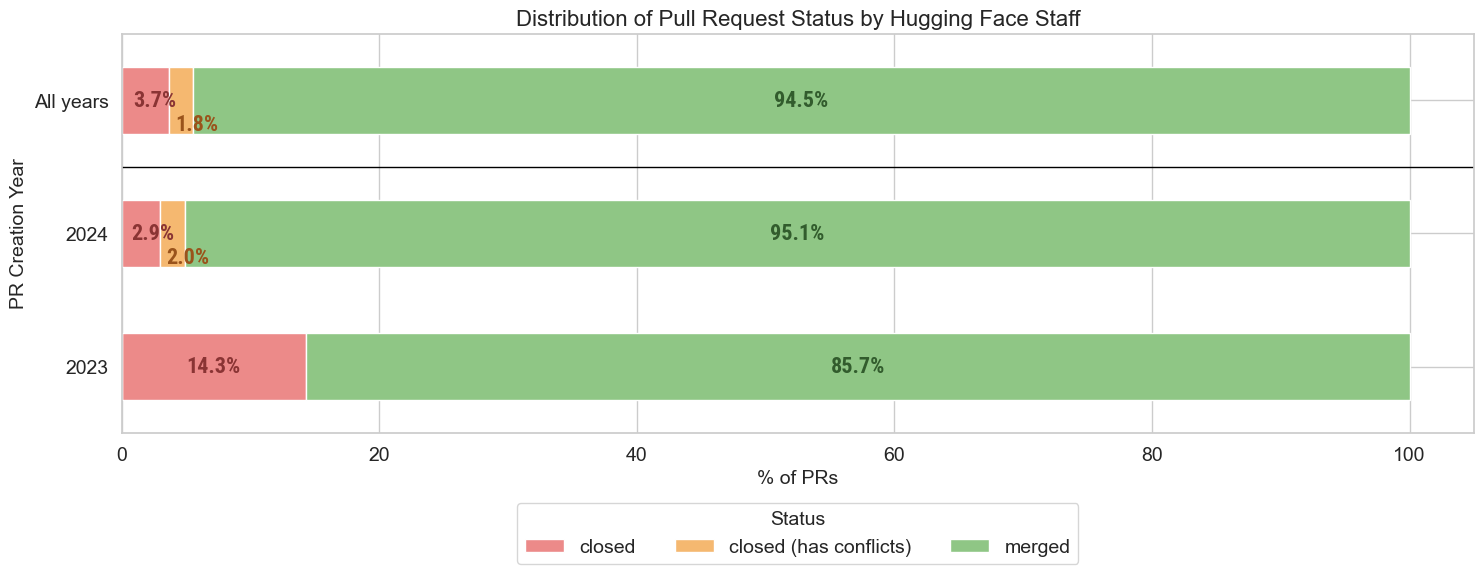

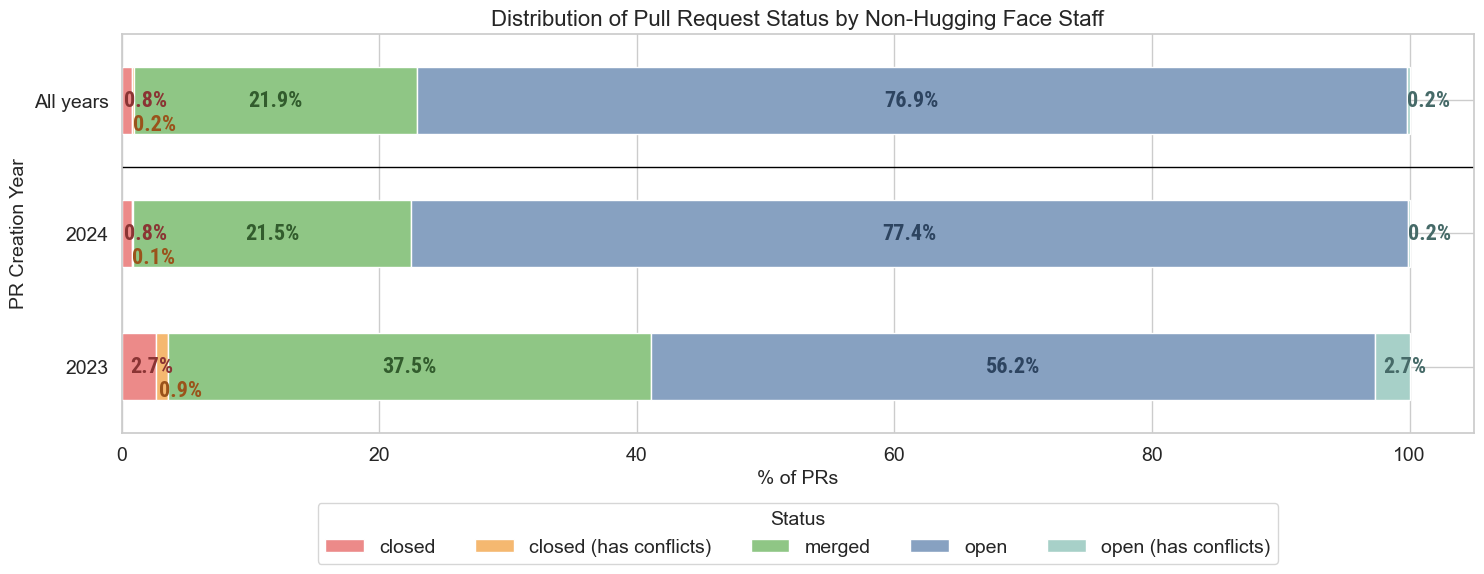

(109, 4564)

In [77]:
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
from nb_utils import RESULTS_DIR

def plot(df, title_suffix):
    
    
    # Group by year and status, and calculate counts
    status_counts = df.groupby(['year', 'status']).size().unstack(fill_value=0)
    
    # Calculate percentage distribution for each year
    status_percentage = status_counts.div(status_counts.sum(axis=1), axis=0) * 100
    
    # Calculate total counts for all years and add as a new row
    total_counts = df['status'].value_counts(normalize=True) * 100  # Percentage distribution for the entire dataset
    status_percentage.loc['All years'] = total_counts.reindex(status_percentage.columns).fillna(0)  # Add 'Total' row
    
    # Define Tableau-like color palette for the status categories
    colors = {
        'open': '#87a1c1',  # Lighter Blue
        'merged': '#8fc685',  # Lighter Green
        'closed': '#ec8a89',  # Lighter Red
        'closed (has conflicts)': '#f5b870',  # Lighter Orange
        'open (has conflicts)': '#a7d0c8',  # Lighter Teal
    }
    
    # Define even darker versions of the Tableau-like color palette
    darker_colors = {
        'open': '#2d4460',  # Even Darker Blue
        'merged': '#325c2d',  # Even Darker Green
        'closed': '#8a3434',  # Even Darker Red
        'closed (has conflicts)': '#9a531b',  # Even Darker Orange
        'open (has conflicts)': '#466a68',  # Even Darker Teal
    }
    
    # Load the Roboto Condensed font from your local assets folder
    roboto_condensed = FontProperties(fname='../../assets/RobotoCondensed-Bold.ttf')
    
    # Plot the 100% stacked bar chart as horizontal with Tableau-like colors
    fig, ax = plt.subplots(figsize=(15, 6))
    status_percentage.plot(kind='barh', stacked=True, ax=ax, color=[colors[status] for status in status_percentage.columns])
    
    # Add data labels for each segment with matching colors
    for i, (year, row) in enumerate(status_percentage.iterrows()):
        cumulative = 0
        delta = 0.18  # Offset for small segments
        was_small = False
        for status, value in row.items():
            if value > 5:  # Only display labels for segments > 5% to prevent overlap
                ax.text(cumulative + value / 2, i, f"{value:.1f}%", ha='center', va='center',
                        fontsize=16, fontweight='bold', fontproperties=roboto_condensed,
                        color=darker_colors[status])  # Set text color to match bar color
                was_small = False
            elif value > 0:
                # For small segments, place the label outside with matching color
                ax.text(cumulative + value / 4, i + (delta if was_small else 0), f"{value:.1f}%", ha='left', va='center',
                        fontsize=16, fontweight='bold', fontproperties=roboto_condensed,
                        color=darker_colors[status])
                delta = -delta
                was_small = True
            cumulative += value
    
    # Add a red line separating the "Total" bar from the yearly data
    ax.axhline(y=len(status_percentage) - 1.5, color='black', linewidth=1)
    
    # Customize plot with larger font sizes
    plt.title(f'Distribution of Pull Request Status by {title_suffix}', fontsize=16)
    plt.ylabel('PR Creation Year', fontsize=14)
    plt.xlabel('% of PRs', fontsize=14)
    # increase tick size
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    # Move the legend outside and below the chart with increased label size
    plt.legend(title='Status', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=len(status_percentage.columns),
               fontsize=14, title_fontsize=14)
    plt.tight_layout()
    
    # Save the plot to a PDF
    plt.savefig(RESULTS_DIR / f'RQ4StatusDistribution-{title_suffix}.pdf', format='pdf', bbox_inches='tight')
    
    plt.show()

# filter df1 to only include PRs that were merged by hugging face staff
df1_hf_staff = df[df['was_status_changed_by_hf_staff'] == True]
plot(df1_hf_staff, 'Hugging Face Staff')

# filter df1 to only include PRs that were merged by non-hugging face staff
df1_non_hf_staff = df[df['was_status_changed_by_hf_staff'] == False]
plot(df1_non_hf_staff, 'Non-Hugging Face Staff')
len(df1_hf_staff), len(df1_non_hf_staff)

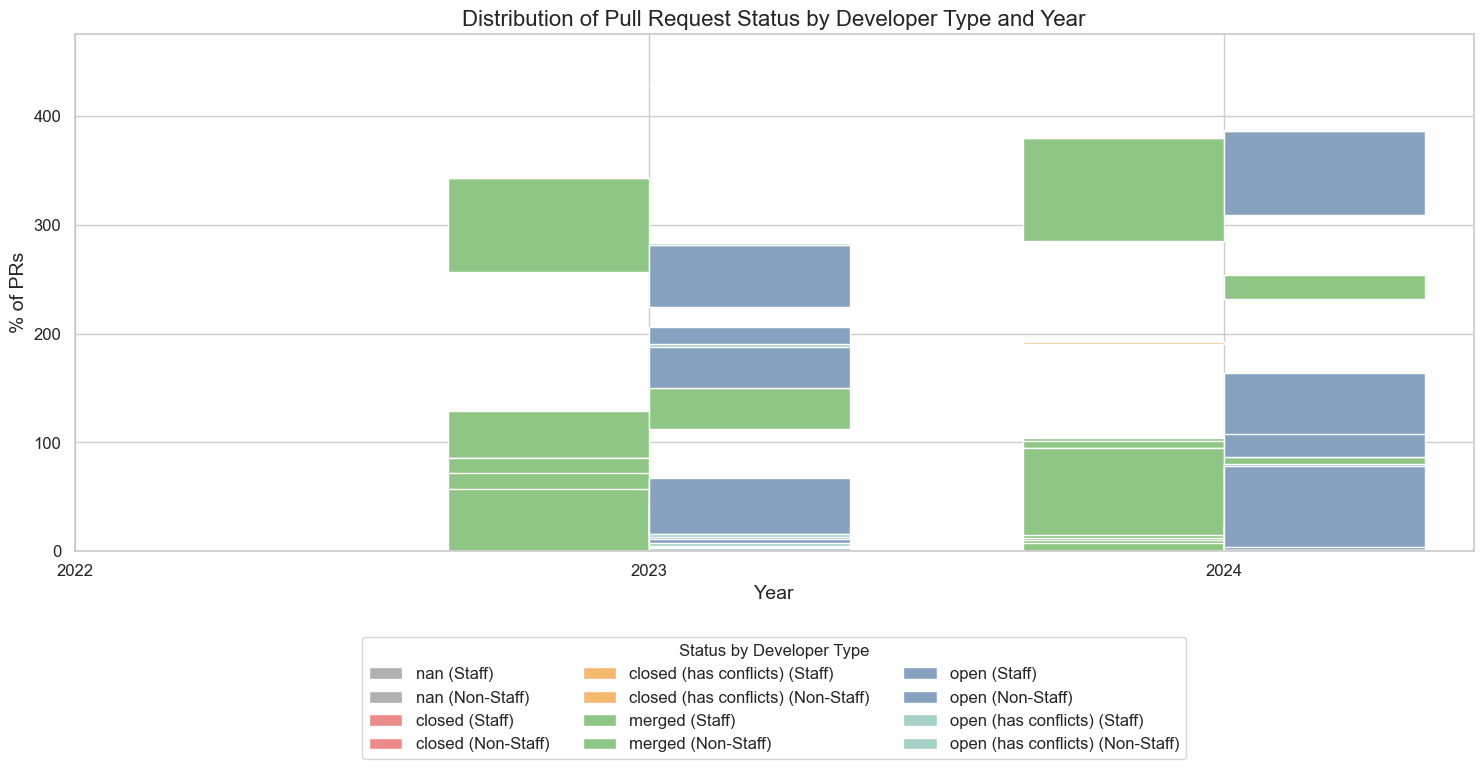

In [76]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import pandas as pd



# Function to plot the combined stacked bar chart for PR status by developer type and year
def plot_combined(df):
    # Define all possible combinations of year, developer type, and status
    years = sorted(df['year'].unique())
    developer_types = [True, False]  # Hugging Face staff (True) or not (False)
    statuses = df['status'].unique()
    multi_index = pd.MultiIndex.from_product([years, developer_types, statuses], names=['year', 'was_status_changed_by_hf_staff', 'status'])
    
    # Group by year, developer type, and status, then calculate counts
    status_counts = df.groupby(['year', 'was_status_changed_by_hf_staff', 'status']).size().reindex(multi_index, fill_value=0).unstack(fill_value=0)
    
    # Calculate percentage distribution for each year and developer type
    status_percentage = status_counts.div(status_counts.sum(axis=1), axis=0) * 100
    
    # Define Tableau-like color palette for the status categories
    colors = {
        'open': '#87a1c1',  # Lighter Blue
        'merged': '#8fc685',  # Lighter Green
        'closed': '#ec8a89',  # Lighter Red
        'closed (has conflicts)': '#f5b870',  # Lighter Orange
        'open (has conflicts)': '#a7d0c8',  # Lighter Teal
    }
    
    # Define bar width for side-by-side bars within each year
    bar_width = 0.35

    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Plot for each year
    for i, year in enumerate(years):
        # Select data for the year, split by staff and non-staff
        staff_data = status_percentage.loc[(year, True)]
        non_staff_data = status_percentage.loc[(year, False)]
        
        # Plot bars for staff and non-staff side by side within the same year
        bottom_staff = [0] * len(staff_data)
        bottom_non_staff = [0] * len(non_staff_data)
        
        for status in staff_data.index:
            ax.bar(i - bar_width/2, staff_data[status], bar_width, label=f'{status} (Staff)' if i == 0 else "", color=colors.get(status, '#b0b0b0'), bottom=bottom_staff)
            ax.bar(i + bar_width/2, non_staff_data[status], bar_width, label=f'{status} (Non-Staff)' if i == 0 else "", color=colors.get(status, '#b0b0b0'), bottom=bottom_non_staff)
            
            bottom_staff = [sum(x) for x in zip(bottom_staff, staff_data)]
            bottom_non_staff = [sum(x) for x in zip(bottom_non_staff, non_staff_data)]
    
    # Customize the plot
    plt.title("Distribution of Pull Request Status by Developer Type and Year", fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('% of PRs', fontsize=14)
    ax.set_xticks(range(len(years)))
    ax.set_xticklabels(years)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Move the legend below the chart
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3, fontsize=12, title="Status by Developer Type")
    plt.tight_layout()
    
    # Save the plot to a PDF
    plt.savefig(f"{RESULTS_DIR}/Combined_Status_Distribution.pdf", format='pdf', bbox_inches='tight')
    
    plt.show()

# Call the combined plot function
plot_combined(df)


## Time to response
We plot a box plot of the time to first response for each status category.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from nb_utils import RESULTS_DIR

# Filter out PRs with no response
df_time_to_response = df[df['time_to_first_response'] != 'No response']
# Convert time to response to minutes
df_time_to_response['time_to_first_response'] = pd.to_timedelta(df_time_to_response['time_to_first_response'])
df_time_to_response['time_to_first_response'] = df_time_to_response[
                                                    'time_to_first_response'].dt.total_seconds() / 60  #3600
# Plot the box plot
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")
# do a box plot including the outliers in the plot (dont leave it out as circles)
sns.boxplot(data=df_time_to_response, x='status', y='time_to_first_response', showfliers=True)
sns.boxplot(data=df_time_to_response, x='status', y='time_to_first_response', showfliers=True)
# sns.boxplot(data=df_time_to_response, x='status', y='time_to_first_response', palette=colors)
# do a violin plot
# sns.violinplot(data=df_time_to_response, x='status', y='time_to_first_response', palette=colors)
plt.yscale('log')  # Log scale for better visualization
plt.title('Time to First Response by PR Status')
plt.xlabel('PR Status')
plt.ylabel('Time to First Response (hours)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'RQ4TimeToFirstResponse.pdf', format='pdf')
plt.show()



## Identify Relevant Discussions

Criteria:
1. PR has at least two non-empty comment.
2. PR has at least two different authors (not counting the SFConvertBot) engaging in the discussion.
3. The average comment size is more than 4 words.

In [ ]:
from nb_utils import RESULTS_DIR
from tqdm import tqdm
import json

min_num_authors = 2
min_num_comments = 2
min_avg_comment_size = 0

output_file = RESULTS_DIR / 'sfconvertbot_pr_metadata_filtered.csv'
# create a dataframe to store the filtered PRs
df_filtered = pd.DataFrame(columns=df.columns)
# create lambda function that checks whether string.lower() == 'sfconvertbot'
is_sfconvertbot = lambda x: x.lower() == 'sfconvertbot'

# iterate over dataframe
for index, row in tqdm(df.iterrows(), total=len(df)):
    # parse as JSON (it should be a string)
    discussion = json.loads(row['discussion_metadata'])['discussion']
    # extract events and original author
    events = discussion['events']
    original_author = discussion['author']
    # criteria:
    num_words, num_non_empty_comments = 0, 0
    authors = set()
    if not is_sfconvertbot(original_author["name"]):
        authors.add(original_author["name"])

    for event in events:
        # print("\t",event)
        event_type = event['type']
        if event_type == 'comment' and not event['data']['hidden']:
            event_author = event['author']
            num_non_empty_comments += 1
            if not is_sfconvertbot(event_author["name"]):
                authors.add(event_author["name"])
            num_words += len(event['data']['latest']['raw'].split())

    should_include = (num_non_empty_comments >= min_num_comments and
                      len(authors) >= min_num_authors and
                      num_words / num_non_empty_comments >= min_avg_comment_size)
    # add the row to the filtered dataframe
    if should_include:
        df_filtered.loc[len(df_filtered)] = row
        title = f"{discussion['title']} by {original_author['name']} ({row['model_id']})"
        df_filtered.loc[len(df_filtered) - 1, 'title'] = title
        df_filtered.loc[len(df_filtered) - 1, 'num_comments'] = num_non_empty_comments
        df_filtered.loc[len(df_filtered) - 1, 'num_authors'] = len(authors)
        df_filtered.loc[len(df_filtered) - 1, 'avg_comment_size'] = num_words / num_non_empty_comments
        df_filtered.loc[len(df_filtered) - 1, 'authors'] = ";".join(authors)

# add a source column
df_filtered['source'] = 'SFConvertBot PRs'
# rename PR URL column to url
df_filtered.rename(columns={'pr_url': 'url'}, inplace=True)
# rename discussion_metadata to json_content
df_filtered.rename(columns={'discussion_metadata': 'json_content'}, inplace=True)
# reorder columns
df_filtered = df_filtered[['source', 'title', 'url', 'num_comments', 'num_authors', 'avg_comment_size', 'authors']]
# save the filtered dataframe
df_filtered.to_csv(output_file, index=True)
print("Number of PRs after filtering: ", len(df_filtered))
print("Saved to: ", output_file)